<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter5/5_1_%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB_Pyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title install packages
!pip install watermark
!pip install japanize-matplotlib
# !pip install torch==1.10.0
# !pip install pyro-ppl==1.7.0
!pip install pyro-ppl

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

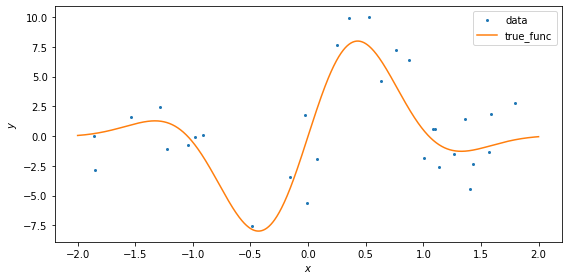

In [ ]:
np.random.seed(20)

# データ数
N = 30

# 目的変数生成関数
def make_data(x, eps):
  y = 10*np.sin(3*x) * np.exp(-x**2)
  noise = np.random.normal(0, eps, size=x.shape[0])
  return y+ noise

# 説明変数をサンプリング
x_data = np.random.uniform(low=-2., high=2., size=N)
# 目的変数生成
y_data =  make_data(x_data, 2.0)
# 関数可視化用説明変数
x_linspace = np.linspace(-2., 2., 1000)
# 関数可視化用目的変数
y_linspace = make_data(x_linspace, 0.0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x_data, y_data, 'o', markersize=2, label='data');
ax.plot(x_linspace, y_linspace, label='true_func')
ax.set_xlabel('$x$');ax.set_ylabel('$y$')
ax.legend()
plt.tight_layout();

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, DenseNN
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

In [ ]:
# モデリング方法1
# 隠れ層の次元
h1, h2 = 10, 10

class Model(PyroModule):
    # 各コンポーネントを定義
    def __init__(self, h1=h1, h2=h2):
        super().__init__()
        # 第1層（確率変数のbatchshapeをeventshapeにする）
        self.fc1 = PyroModule[nn.Linear](1, h1)
        self.fc1.weight = PyroSample(dist.Normal(0.,10.).expand([h1, 1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0.,10.).expand([h1]).to_event(1))
        # 第2層
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0.,10.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0.,10.).expand([h2]).to_event(1))
        # 出力層
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0.,10.).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0.,10.).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    # データの生成過程を記述
    def forward(self, X, Y=None, h1=h1, h2=h2):
        # ニューラルネットワークの出力
        X = self.relu(self.fc1(X))
        X = self.relu(self.fc2(X))
        mu = self.fc3(X)
        # 観測ノイズの標準偏差をサンプリング
        sigma = pyro.sample("sigma", dist.Uniform(0.,2.0))
        # 尤度の積
        with pyro.plate("data", X.shape[0]):
          # shapeが(N, 1)であるため, 右の1をeventshapeにする
          obs = pyro.sample("Y", dist.Normal(mu, sigma).to_event(1), obs=Y)
        # 全ての軸をevent_shapeにしても計算はできる
        #obs = pyro.sample("Y", dist.Normal(mu, sigma).to_event(2), obs=Y)
        return mu
        
# インスタンス化
model = Model(h1=h1, h2=h2)

In [ ]:
# # モデリング方法2
# # 隠れ層の次元
# h1, h2 = 10, 10

# # relu関数
# def relu(x):
#     return torch.max(x, torch.tensor(0.))

# def model(X, Y, h1, h2):
#     # バイアス付与
#     X = torch.pow(X, torch.arange(2))
#     D_X = X.shape[1]
    
#     # 第1層の重みをサンプリング
#     w1 = pyro.sample(
#         "w1", dist.Normal(torch.zeros((D_X, h1)), 10.0*torch.ones((D_X, h1))).to_event(2)
#     ) 
#     # 第1層の線形結合と非線形変換
#     z1 = relu(torch.matmul(X, w1)) 

#     # 第2層の重みをサンプリング
#     w2 = pyro.sample(
#         "w2", dist.Normal(torch.zeros((h1, h2)), 10.0*torch.ones((h1, h2))).to_event(2)
#     ) 
#     # 第2層の線形結合と非線形変換
#     z2 = relu(torch.matmul(z1, w2)) 

#     # 出力層の重みをサンプリング
#     w3 = pyro.sample(
#         "w3", dist.Normal(torch.zeros((h2, 1)), 10.0*torch.ones((h2, 1))).to_event(2)
#     ) 
#     # 出力層の線形結合と非線形変換
#     z3 = torch.matmul(z2, w3)  

#     # 観測ノイズの標準偏差をサンプリング
#     sigma_obs = pyro.sample('noise_obs', dist.Uniform(0.0, 2.0))
#     # 尤度の積
#     with pyro.plate("data", X.shape[0]):
#       obs = pyro.sample("Y", dist.Normal(z3, sigma_obs).to_event(1), obs=Y)

#     # 全ての軸をevent_shapeにしても計算はできる
#     # obs = pyro.sample("Y", dist.Normal(z3, sigma_obs).to_event(2), obs=Y)

In [ ]:
# パラメータをリセット
pyro.clear_param_store()
# 近似分布の設定
guide = AutoDiagonalNormal(model)
# optimizerの設定
adam = pyro.optim.Adam({"lr": 0.03})
# SVIクラスのインスタンス化
svi = SVI(model, guide, adam, loss=Trace_ELBO())

# データをtensorに変換
x_data = torch.from_numpy(x_data).float().unsqueeze(-1)
y_data = torch.from_numpy(y_data).float().unsqueeze(-1)

# 最適化
torch.manual_seed(0)
n_epoch = 10000
loss_list = []
for epoch in range(n_epoch):

    # 変分推論の最適化ステップ
    loss = svi.step(x_data, y_data, h1, h2)
    loss_list.append(loss)
   

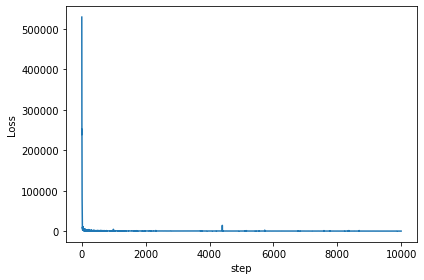

In [ ]:
# 損失関数の可視化
plt.plot(np.array(loss_list))
plt.xlabel('step')
plt.ylabel('Loss')
plt.tight_layout();

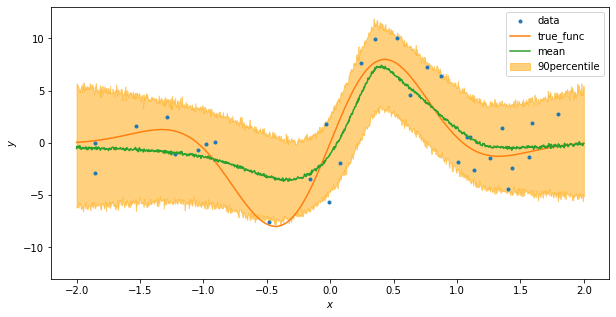

In [ ]:
# 近似分布からのサンプルを利用した予測分布
predictive = Predictive(model, guide=guide, num_samples=500)

# 新規データ
x_new = torch.linspace(-2.0, 2.0, 1000).unsqueeze(-1)
# 新規データを入力して予測分布を出力
y_pred_samples = predictive(x_new, None, h1, h2)['Y'] 
# 予測分布のからのサンプルの平均
y_pred_mean = y_pred_samples.mean(axis=0)
# 予測分布からのサンプルの90パーセンタイル
percentiles = np.percentile(y_pred_samples.squeeze(-1), [5.0, 95.0], axis=0)

fig, ax = plt.subplots(figsize=(10, 5))
# データ可視化
ax.plot(x_data, y_data, 'o', markersize=3, label='data')
# 真の関数
ax.plot(x_linspace, y_linspace, label='true_func')
# 予測分布の平均
ax.plot(x_new, y_pred_mean, label='mean')
# 予測分布の90パーセンタイル
ax.fill_between(x_new.squeeze(-1), percentiles[0, :], percentiles[1, :],
                  alpha=0.5, label='90percentile', color='orange')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_ylim(-13 ,13)
ax.legend();

In [ ]:
%load_ext watermark
%watermark --iversions

pandas    : 1.3.5
seaborn   : 0.11.2
numpy     : 1.21.6
matplotlib: 3.2.2
arviz     : 0.12.1
scipy     : 1.4.1
pyro      : 1.8.1
torch     : 1.11.0+cu113
IPython   : 5.5.0

